# Exercice TicTacTrip

*Arthur Lemerle, 5 avril 2022*

Sans faire d'introduction longue et ennuyeuse, je voulais tout de même faire quelques remarques en plus de celles que j'ai faites au fur et à mesure de l'exercice. 
La première, c'est que j'ai appris pas mal de choses en travaillant sur cet exercice. J'ai assez vite réfléchi en mode "bases de données"/"SQL", et j'ai donc utilisé pandas de cette manière-là assez régulièrement. Je n'y étais pas forcément habitué (j'aurais été plus à l'aise directement en SQL) mais j'ai trouvé super intéressant et stimulant de traduire tout ça en python grâce à pandas.
En essayant par endroits de me simplifier la vie, j'ai aussi découvert des bibliothèques que je ne connaissais pas : geodesic pour le calcul des distances à partir des coordonnées logitudes/latitudes; et la fonction to_datatime de pandas pour calculer facilement le temps des trajets.
J'ai sinon essayé d'expliquer partout ce que je faisais. Mon rapport se lit dans l'ordre, au fur et à mesure. J'ai tout le temps vérifié sur des exemples particuliers que les résultats (distances/temps/moyennes etc.) étaient corrects, mais j'ai supprimé du notebook ces vérifications pour qu'il soit le plus lisible possible.

In [1]:
# Import the useful libraries
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import tensorflow as tf
import math

/Users/arthurlemerle/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
# Make the data available. The user should simply copy/paste the path to the folder "Data" from its own computer.
data_folder = '/Users/arthurlemerle/Desktop/TicTacTrip/Data'

# Load the different data sets into the environment
ticket_data = pd.read_csv(data_folder+"/ticket_data.csv")
cities = pd.read_csv(data_folder+"/cities.csv")
providers = pd.read_csv(data_folder+"/providers.csv")
stations = pd.read_csv(data_folder+"/stations.csv")

Maintenant que toutes les données sont chargées dans notre environnement, nous utilisons quelques commandes simples pour se familiariser avec le data set ticket_data.

In [3]:
# We look at the 5 first rows of the tickets data set to see what it contains
ticket_data.head()

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542


In [4]:
# We print some interesting statistics about the data
ticket_data.describe()

,id,company,o_station,d_station,price_in_cents,o_city,d_city
count,7.416800e+04,74168.000000,32727.000000,32727.000000,74168.000000,74168.000000,74168.000000
mean,6.832108e+06,7109.565527,2907.132673,2347.858129,4382.711061,849.186105,883.776265
std,2.141060e+04,3005.380792,3347.629180,3090.798007,3739.325367,1485.791782,1654.698575
min,6.795025e+06,9.000000,3.000000,3.000000,300.000000,5.000000,1.000000
25%,6.813567e+06,8376.000000,400.000000,396.000000,1900.000000,485.000000,453.000000
50%,6.832108e+06,8385.000000,701.000000,575.000000,3350.000000,628.000000,562.000000
75%,6.850650e+06,8385.000000,6246.000000,4538.000000,5250.000000,628.000000,628.000000
max,6.869192e+06,8387.000000,11017.000000,11017.000000,38550.000000,12190.000000,12190.000000


In [5]:
# Dimensions of the data frame
ticket_data.shape

(74168, 12)

In [6]:
# Additional knowledge on the data
ticket_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74168 entries, 0 to 74167
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               74168 non-null  int64  
 1   company          74168 non-null  int64  
 2   o_station        32727 non-null  float64
 3   d_station        32727 non-null  float64
 4   departure_ts     74168 non-null  object 
 5   arrival_ts       74168 non-null  object 
 6   price_in_cents   74168 non-null  int64  
 7   search_ts        74168 non-null  object 
 8   middle_stations  32727 non-null  object 
 9   other_companies  32727 non-null  object 
 10  o_city           74168 non-null  int64  
 11  d_city           74168 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 6.8+ MB


Nous nous attaquons maintenant à déterminer des informations relatives à la durée des trajets.

In [7]:
# We begin by selecting the columns of interest : the departure time and the arrival time
horaires_depart=ticket_data['departure_ts']
horaires_arrivee=ticket_data['arrival_ts']

# We convert these dates into timestamps objects, easier to manipulate
horaires_depart=pd.to_datetime(horaires_depart, utc=True, format = "%Y-%m-%d %H:%M:%S")
horaires_arrivee=pd.to_datetime(horaires_arrivee, utc=True, format = "%Y-%m-%d %H:%M:%S")

# We add to our data set a new column corresponding to the time of travel
ticket_data['temps_trajet_total_minutes']=(horaires_arrivee-horaires_depart).dt.total_seconds()/60

# We print the result to make sure that what we have is correct. By hand, it is easy to check on a few examples that we have found the total time of each travel
ticket_data.head()

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,temps_trajet_total_minutes
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542,370.0
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,1070.0
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542,1917.0
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542,1295.0
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542,1306.0


On peut maintenant obtenir facilement quelques statistiques sur les temps de trajet.

In [8]:
# We print some statistics of interest :
ticket_data["temps_trajet_total_minutes"].describe()

count    74168.000000
mean       424.620793
std        594.981356
min         20.000000
25%        180.000000
50%        290.000000
75%        480.000000
max      29571.000000
Name: temps_trajet_total_minutes, dtype: float64

In [9]:
ticket_data["price_in_cents"].describe()

count    74168.000000
mean      4382.711061
std       3739.325367
min        300.000000
25%       1900.000000
50%       3350.000000
75%       5250.000000
max      38550.000000
Name: price_in_cents, dtype: float64

On constate ainsi que : 
- la durée minimum des trajets recensés est de 20min.
- la durée maximum des trajets est de 29571min, soit plus de 20 jours.
- En moyenne, un trajet dure 424,6min ; soit un peu plus de 7h45.

Par ailleurs : 
- le prix minimum des trajets recensés est de 300 cents.
- le prix maximum des trajets recensés est de 38550 cents.
- le prix moyen est de 4383 cents environ.

Nous déterminons maintenant les différences de prix moyen et de durée en fonction du mode de transport et de la distance de trajet.

Pour commencer, essayons de comprendre un peu mieux la signification des données.

In [10]:
# We check whether some values are missing
ticket_data.isnull().sum()    

id                                0
company                           0
o_station                     41441
d_station                     41441
departure_ts                      0
arrival_ts                        0
price_in_cents                    0
search_ts                         0
middle_stations               41441
other_companies               41441
o_city                            0
d_city                            0
temps_trajet_total_minutes        0
dtype: int64

Intuitivement, on peut se dire que les tickets n'ayant pas de stations de départ/arrivée correspondent à du co-voiturage dont une des caractéristiques consiste à partir de lieux spécifiques, et non de stations. Pour vérifier cela, regardons les compagnies qui proposent du covoiturage.

In [11]:
# We determine which providers propose carpooling
providers[(providers["transport_type"]=="carpooling")].drop_duplicates()

,id,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
223,8385,11,NaN,bbc,Blablacar,False,False,False,False,carpooling
226,8389,12,NaN,idvroom,idVroom,False,False,False,False,carpooling


On constate que seules 2 compagnies (id 8385 et id 8389) proposent du co-voiturage. Regardons alors si ce sont bien les mêmes qui sont impliquées dans les tickets n'ayant pas de stations de départ/d'arrivée.

In [12]:
# We select the companies involved in some tickets and having no values for o_station/d_station
no_stations=ticket_data[(ticket_data["o_station"].isnull())]
no_stations[["company"]].drop_duplicates()

,company
0,8385


In [13]:
no_stations[["company"]].count()

company    41441
dtype: int64

On constate donc bien que les 41441 lignes données manquantes dans les stations de départ/arrivée des tickets correspondent à des trajets de co-voiturage (qui plus est avec Blablacar exclusivement).

Nous adoptons alors la stratégie suivante : 
    - nous considérerons la distance ville_départ/ville_arrivée pour les trajets en co-voiturage.
    - nous considérerons la distance station_départ/station_arrivée pour les trajets impliquant le bus/train.

In [14]:
# We initialize a new column in the ticket data_set corresponding to the distance of each travel
ticket_data["Distances"]=pd.Series()

# We firstly select the tickets corresponding to carpooling travels.
ticket_covoit=ticket_data[(ticket_data["company"]==8385) | (ticket_data["company"]==8389 )]

# We only keep the columns of interest 
ticket_covoit=ticket_covoit[["id","company", "price_in_cents","o_city","d_city", "temps_trajet_total_minutes", "Distances"]]
ticket_covoit.head()

/Users/arthurlemerle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,id,company,price_in_cents,o_city,d_city,temps_trajet_total_minutes,Distances
0,6795025,8385,4550,611,542,370.0,NaN
5,6795030,8385,1800,628,453,180.0,NaN
6,6795031,8385,2150,628,453,150.0,NaN
7,6795032,8385,1700,628,453,150.0,NaN
8,6795033,8385,1700,628,453,170.0,NaN


In [15]:
ticket_covoit.shape

(41441, 7)

Il s'agit maintenant de calculer à proprement parler les distances entre villes de départ et villes d'arrivée pour du covoiturage. Pour ce faire, nous allons faire 2 jointures sur la table "stations" afin de récupérer les coordonnéees latitude/longitude de chacune des villes de départ et d'arrivée.

In [16]:
# First Join, we only keep the id, name and coordinates of the cities. Left_on is the departure city
ticket_covoit_cities= pd.merge(ticket_covoit, cities[["id", "unique_name", "latitude", "longitude"]], how='left', left_on='o_city', right_on='id')
ticket_covoit_cities.head()

,id_x,company,price_in_cents,o_city,d_city,temps_trajet_total_minutes,Distances,id_y,unique_name,latitude,longitude
0,6795025,8385,4550,611,542,370.0,NaN,611,orleans,47.907018,1.906270
1,6795030,8385,1800,628,453,180.0,NaN,628,paris,48.847702,2.352311
2,6795031,8385,2150,628,453,150.0,NaN,628,paris,48.847702,2.352311
3,6795032,8385,1700,628,453,150.0,NaN,628,paris,48.847702,2.352311
4,6795033,8385,1700,628,453,170.0,NaN,628,paris,48.847702,2.352311


In [17]:
# Second Join. Left_on is the arrival city
ticket_covoit_cities=pd.merge(ticket_covoit_cities,cities[["id", "unique_name", "latitude", "longitude"]], how='left', left_on='d_city', right_on='id')
ticket_covoit_cities.head()

,id_x,company,price_in_cents,o_city,d_city,temps_trajet_total_minutes,Distances,id_y,unique_name_x,latitude_x,longitude_x,id,unique_name_y,latitude_y,longitude_y
0,6795025,8385,4550,611,542,370.0,NaN,611,orleans,47.907018,1.906270,542,montpellier,43.604452,3.918318
1,6795030,8385,1800,628,453,180.0,NaN,628,paris,48.847702,2.352311,453,lille,50.638756,3.076675
2,6795031,8385,2150,628,453,150.0,NaN,628,paris,48.847702,2.352311,453,lille,50.638756,3.076675
3,6795032,8385,1700,628,453,150.0,NaN,628,paris,48.847702,2.352311,453,lille,50.638756,3.076675
4,6795033,8385,1700,628,453,170.0,NaN,628,paris,48.847702,2.352311,453,lille,50.638756,3.076675


In [18]:
ticket_covoit_cities.shape

(41441, 15)

In [19]:
# To check that we have the accurate cities/lat/long we can check on a few id cities that appear above :)...
cities[cities["id"]==453]

,id,local_name,unique_name,latitude,longitude,population
5382,453,"Lille, Hauts-de-France, France",lille,50.638756,3.076675,233897.0


On peut maitenant remplir la colonne "Distances". Je crée ici une petite fonction dont je me sers à 2 reprises. Les arguments sont des colonnes de data sets (des pd.Series), et on crée une novelle pd.Series correspondant à la distance.

In [20]:
def distances(latX, longX, latY, longY):
    n=latX.shape[0]
    distance = pd.Series(0, range(n))
    for i in range(n):
        coord_o=(latX[i],longX[i])
        coord_d=(latY[i],longY[i])
        distance[i]=geodesic(coord_o,coord_d)
    return distance

In [21]:
ticket_covoit_cities["Distances"]=distances(ticket_covoit_cities["latitude_x"],ticket_covoit_cities["longitude_x"],ticket_covoit_cities["latitude_y"],ticket_covoit_cities["longitude_y"])
ticket_covoit_cities.head()

,id_x,company,price_in_cents,o_city,d_city,temps_trajet_total_minutes,Distances,id_y,unique_name_x,latitude_x,longitude_x,id,unique_name_y,latitude_y,longitude_y
0,6795025,8385,4550,611,542,370.0,503.1368310487561 km,611,orleans,47.907018,1.906270,542,montpellier,43.604452,3.918318
1,6795030,8385,1800,628,453,180.0,205.93367104658697 km,628,paris,48.847702,2.352311,453,lille,50.638756,3.076675
2,6795031,8385,2150,628,453,150.0,205.93367104658697 km,628,paris,48.847702,2.352311,453,lille,50.638756,3.076675
3,6795032,8385,1700,628,453,150.0,205.93367104658697 km,628,paris,48.847702,2.352311,453,lille,50.638756,3.076675
4,6795033,8385,1700,628,453,170.0,205.93367104658697 km,628,paris,48.847702,2.352311,453,lille,50.638756,3.076675


Remarque : cette méthode n'est pas très optimisée dans la mesure où les distances sont calculées pour chaque ticket, alors que de nombreux tickets relient les mêmes villes : rien que dans les 5 premiers tickets, on constate que 4 correspondent au même trajet Paris-Lille.
Pour gagner du temps de calcul, on pourrait plutôt créer un tableau avec les distances entre toutes les villes 2 à 2, que nous calculerions donc une unique fois. C'est ce que je ferai si je trouve le temps :)

In [22]:
# We keep what is useful for us now
ticket_covoit_cities=ticket_covoit_cities[["Distances","temps_trajet_total_minutes","price_in_cents"]]

#We can add the type of transportation. (We could also make a merge, this is what we'll do for trains and buses)
ticket_covoit_cities["transport_type"]=pd.Series("carpooling", range(ticket_covoit_cities.shape[0]))
ticket_covoit_cities.head()

,Distances,temps_trajet_total_minutes,price_in_cents,transport_type
0,503.1368310487561 km,370.0,4550,carpooling
1,205.93367104658697 km,180.0,1800,carpooling
2,205.93367104658697 km,150.0,2150,carpooling
3,205.93367104658697 km,150.0,1700,carpooling
4,205.93367104658697 km,170.0,1700,carpooling


In [23]:
ticket_covoit_cities.shape

(41441, 4)

Maintenant que nous avons traité le cas "covoiturage" avec distances entre villes, nous pouvons passer au cas bus/train avec distances entre stations.

In [24]:
# We firstly select the tickets corresponding to non-carpooling travels (bus or train)
ticket_pas_covoit=ticket_data[(ticket_data["company"]!=8385) & (ticket_data["company"]!=8389 )]

# We only keep the columns which are of interest
ticket_pas_covoit=ticket_pas_covoit[["id","company", "price_in_cents","o_station","d_station", "temps_trajet_total_minutes", "Distances"]]
ticket_pas_covoit.head()

,id,company,price_in_cents,o_station,d_station,temps_trajet_total_minutes,Distances
1,6795026,9,1450,63.0,1044.0,1070.0,NaN
2,6795027,8377,7400,5905.0,6495.0,1917.0,NaN
3,6795028,8377,13500,5905.0,6495.0,1295.0,NaN
4,6795029,8381,7710,5905.0,6495.0,1306.0,NaN
49,6795074,13,1990,767.0,396.0,675.0,NaN


Afin de récupérer le type de transport (train ou bus), on peut effectuer une première jointure sur le data set "providers".

In [25]:
ticket_pas_covoit= pd.merge(ticket_pas_covoit, providers[["id","transport_type"]], how='left', left_on='company', right_on='id')

#We keep the useful features
ticket_pas_covoit=ticket_pas_covoit[["id_x","company","price_in_cents","o_station","d_station","temps_trajet_total_minutes","Distances","transport_type"]]
ticket_pas_covoit.head()

,id_x,company,price_in_cents,o_station,d_station,temps_trajet_total_minutes,Distances,transport_type
0,6795026,9,1450,63.0,1044.0,1070.0,NaN,bus
1,6795027,8377,7400,5905.0,6495.0,1917.0,NaN,train
2,6795028,8377,13500,5905.0,6495.0,1295.0,NaN,train
3,6795029,8381,7710,5905.0,6495.0,1306.0,NaN,train
4,6795074,13,1990,767.0,396.0,675.0,NaN,bus


In [26]:
ticket_pas_covoit.shape

(32727, 8)

In [27]:
# First merge to add the departure stations
ticket_stations= pd.merge(ticket_pas_covoit, stations, how='left', left_on='o_station', right_on="id")
ticket_stations.head()

,id_x,company,price_in_cents,o_station,d_station,temps_trajet_total_minutes,Distances,transport_type,id,unique_name,latitude,longitude
0,6795026,9,1450,63.0,1044.0,1070.0,NaN,bus,63,Avenue Georges Pompidou,47.896911,1.854277
1,6795027,8377,7400,5905.0,6495.0,1917.0,NaN,train,5905,Les Aubrais,47.926740,1.906740
2,6795028,8377,13500,5905.0,6495.0,1295.0,NaN,train,5905,Les Aubrais,47.926740,1.906740
3,6795029,8381,7710,5905.0,6495.0,1306.0,NaN,train,5905,Les Aubrais,47.926740,1.906740
4,6795074,13,1990,767.0,396.0,675.0,NaN,bus,767,Massy-Palaiseau,48.727660,2.264629


In [28]:
ticket_stations.shape

(32727, 12)

In [29]:
# Second merge to add the arrival stations
ticket_stations= pd.merge(ticket_stations, stations, how='left', left_on='d_station', right_on="id")
ticket_stations.head()

/Users/arthurlemerle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'id_x'} in the result is deprecated and will raise a MergeError in a future version.
  


,id_x,company,price_in_cents,o_station,d_station,temps_trajet_total_minutes,Distances,transport_type,id_x,unique_name_x,latitude_x,longitude_x,id_y,unique_name_y,latitude_y,longitude_y
0,6795026,9,1450,63.0,1044.0,1070.0,NaN,bus,63,Avenue Georges Pompidou,47.896911,1.854277,1044,Station Les Sabines,43.583932,3.860233
1,6795027,8377,7400,5905.0,6495.0,1917.0,NaN,train,5905,Les Aubrais,47.926740,1.906740,6495,Montpellier,43.604900,3.880500
2,6795028,8377,13500,5905.0,6495.0,1295.0,NaN,train,5905,Les Aubrais,47.926740,1.906740,6495,Montpellier,43.604900,3.880500
3,6795029,8381,7710,5905.0,6495.0,1306.0,NaN,train,5905,Les Aubrais,47.926740,1.906740,6495,Montpellier,43.604900,3.880500
4,6795074,13,1990,767.0,396.0,675.0,NaN,bus,767,Massy-Palaiseau,48.727660,2.264629,396,Gare Lille-Europe,50.638756,3.076675


In [30]:
#We now calculate the distances for each ticket
ticket_stations["Distances"]=distances(ticket_stations["latitude_x"],ticket_stations["longitude_x"],ticket_stations["latitude_y"],ticket_stations["longitude_y"])
ticket_stations.head()

,id_x,company,price_in_cents,o_station,d_station,temps_trajet_total_minutes,Distances,transport_type,id_x,unique_name_x,latitude_x,longitude_x,id_y,unique_name_y,latitude_y,longitude_y
0,6795026,9,1450,63.0,1044.0,1070.0,504.1021289182609 km,bus,63,Avenue Georges Pompidou,47.896911,1.854277,1044,Station Les Sabines,43.583932,3.860233
1,6795027,8377,7400,5905.0,6495.0,1917.0,504.2520886071109 km,train,5905,Les Aubrais,47.926740,1.906740,6495,Montpellier,43.604900,3.880500
2,6795028,8377,13500,5905.0,6495.0,1295.0,504.2520886071109 km,train,5905,Les Aubrais,47.926740,1.906740,6495,Montpellier,43.604900,3.880500
3,6795029,8381,7710,5905.0,6495.0,1306.0,504.2520886071109 km,train,5905,Les Aubrais,47.926740,1.906740,6495,Montpellier,43.604900,3.880500
4,6795074,13,1990,767.0,396.0,675.0,220.48420115530303 km,bus,767,Massy-Palaiseau,48.727660,2.264629,396,Gare Lille-Europe,50.638756,3.076675


In [31]:
ticket_stations=ticket_stations[["Distances","temps_trajet_total_minutes","price_in_cents","transport_type"]]
ticket_stations.head()

,Distances,temps_trajet_total_minutes,price_in_cents,transport_type
0,504.1021289182609 km,1070.0,1450,bus
1,504.2520886071109 km,1917.0,7400,train
2,504.2520886071109 km,1295.0,13500,train
3,504.2520886071109 km,1306.0,7710,train
4,220.48420115530303 km,675.0,1990,bus


In [32]:
ticket_stations.shape

(32727, 4)

On peur maintenant réunir dans un grand tableau toutes les données que nous avons rassemblées :

In [33]:
set_final=pd.concat([ticket_covoit_cities,ticket_stations])
set_final.head()

,Distances,temps_trajet_total_minutes,price_in_cents,transport_type
0,503.1368310487561 km,370.0,4550,carpooling
1,205.93367104658697 km,180.0,1800,carpooling
2,205.93367104658697 km,150.0,2150,carpooling
3,205.93367104658697 km,150.0,1700,carpooling
4,205.93367104658697 km,170.0,1700,carpooling


In [34]:
set_final.shape

(74168, 4)

On peut maintenant différencier les données en 4 groupes de distances : [0;200km], [200;800kms], [800;2000] et >2000. Nous les indiquons respectivement par les numéros 1,2,3 et 4

In [35]:
groupe1=set_final[(set_final["Distances"]<=200)]
groupe2=set_final[(set_final["Distances"]>200) & (set_final["Distances"]<=800)]
groupe3=set_final[(set_final["Distances"]>800) & (set_final["Distances"]<=2000)]
groupe4=set_final[(set_final["Distances"]>2000)]

Nous créons maintenant pour chacune de ces catégories distance des petits data_frame résumant le prix moyen et la durée moyenne en fonction du mode de transport utilisé.
Pour "automatiser" encore un peu plus au lieu de faire 4 copiers-collers, j'aurais pu utiliser un dictionnaire de dictionnaires, mais c'est rapidement illisible. J'ai préféré ici faire quelque chose de plus compréhensible à la lecture, mais de fait un peu moins compact.

In [97]:
support={"bus", "train", "carpooling"}

groupe1_resume={"bus":[0,0],"train":[0,0],"carpooling":[0,0]}
for j in support :
    sous_groupej=groupe1[(groupe1["transport_type"]==j)]
    groupe1_resume[j][0]=sous_groupej["price_in_cents"].mean()
    groupe1_resume[j][1]=sous_groupej["temps_trajet_total_minutes"].mean()
groupe1stats=pd.DataFrame(data=groupe1_resume, index=["prix_moyen","duree_moyenne"])

groupe2_resume={"bus":[0,0],"train":[0,0],"carpooling":[0,0]}
for j in support :
    sous_groupej=groupe2[(groupe2["transport_type"]==j)]
    groupe2_resume[j][0]=sous_groupej["price_in_cents"].mean()
    groupe2_resume[j][1]=sous_groupej["temps_trajet_total_minutes"].mean()
groupe2stats=pd.DataFrame(data=groupe2_resume, index=["prix_moyen","duree_moyenne"])

groupe3_resume={"bus":[0,0],"train":[0,0],"carpooling":[0,0]}
for j in support :
    sous_groupej=groupe3[(groupe3["transport_type"]==j)]
    groupe3_resume[j][0]=sous_groupej["price_in_cents"].mean()
    groupe3_resume[j][1]=sous_groupej["temps_trajet_total_minutes"].mean()
groupe3stats=pd.DataFrame(data=groupe3_resume, index=["prix_moyen","duree_moyenne"])

groupe4_resume={"bus":[0,0],"train":[0,0],"carpooling":[0,0]}
for j in support :
    sous_groupej=groupe4[(groupe4["transport_type"]==j)]
    groupe4_resume[j][0]=sous_groupej["price_in_cents"].mean()
    groupe4_resume[j][1]=sous_groupej["temps_trajet_total_minutes"].mean()
groupe4stats=pd.DataFrame(data=groupe4_resume, index=["prix_moyen","duree_moyenne"])


                       bus        train   carpooling
prix_moyen     2109.564581  3597.305970  1177.352385
duree_moyenne   647.451398   261.668284   117.122374
                       bus        train   carpooling
prix_moyen     3533.660382  9189.725709  3218.064310
duree_moyenne   906.479896   464.235438   285.787874
                       bus         train   carpooling
prix_moyen     6955.783514  15680.126183  8626.545455
duree_moyenne  1652.786232    733.041009   786.013986
               bus  train  carpooling
prix_moyen     NaN    NaN         NaN
duree_moyenne  NaN    NaN         NaN


In [37]:
groupe1stats

,bus,train,carpooling
prix_moyen,2109.564581,3597.305970,1177.352385
duree_moyenne,647.451398,261.668284,117.122374


In [38]:
groupe2stats

,bus,train,carpooling
prix_moyen,3533.660382,9189.725709,3218.064310
duree_moyenne,906.479896,464.235438,285.787874


In [39]:
groupe3stats

,bus,train,carpooling
prix_moyen,6955.783514,15680.126183,8626.545455
duree_moyenne,1652.786232,733.041009,786.013986


In [40]:
groupe4stats

,bus,train,carpooling
prix_moyen,NaN,NaN,NaN
duree_moyenne,NaN,NaN,NaN


Ces petits "tableaux" permettent de répondre à la question 2.
Sur les petits trajets par exemple (inférieurs à 200kms, donc de notre groupe 1), le covoiturage est le moyen de transport qui est le plus économique (plus petit prix moyen) devant le bus et le train.

Pour aller un peu plus loin, nous pouvons commencer par tracer quelques histogrammes pour visualiser plus aisément comment sont réparties les données.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fefd4e4d898>,
      dtype=object)

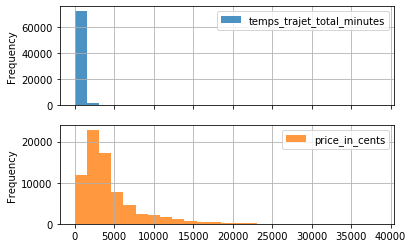

In [41]:
set_final.plot.hist(bins=25, alpha=0.8, subplots=True, grid=True)

Les temps de trajets semblent être très concentrés sur des valeurs "faibles". On peut s'en rendre compte plus facilement avec une boîte à moustaches : 

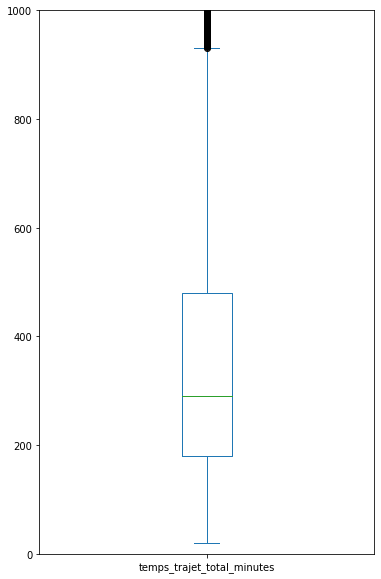

In [42]:
set_final["temps_trajet_total_minutes"].plot.box(figsize=(6, 10),ylim=(0,1000))

Ou alors en "zoomant" un peu sur ce qui se passe au début de cette répartition

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fefd579c3c8>],
      dtype=object)

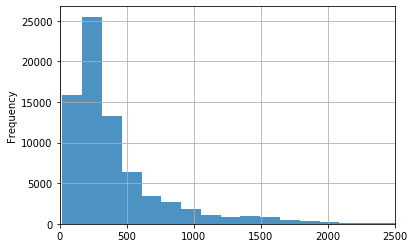

In [43]:
set_final["temps_trajet_total_minutes"].plot.hist(bins=200, alpha=0.8, subplots=True, grid=True, xlim=(0,2500))

On peut aussi s'amuser à faire quelques prédictions avec différents modèles.
Essayons par exemple de trouver le prix d'un ticket en fonction de la distance à parcourir.

In [44]:
set_final.head()

,Distances,temps_trajet_total_minutes,price_in_cents,transport_type
0,503.1368310487561 km,370.0,4550,carpooling
1,205.93367104658697 km,180.0,1800,carpooling
2,205.93367104658697 km,150.0,2150,carpooling
3,205.93367104658697 km,150.0,1700,carpooling
4,205.93367104658697 km,170.0,1700,carpooling


In [45]:
# We firstly convert the distances (geodesic objects) into float
set_final["Distances"]=set_final["Distances"].astype(str).str[:-3].astype(float)

In [46]:
set_final.corr()

,Distances,temps_trajet_total_minutes,price_in_cents
Distances,1.000000,0.392565,0.542543
temps_trajet_total_minutes,0.392565,1.000000,0.159206
price_in_cents,0.542543,0.159206,1.000000


In [47]:
import seaborn as sns

/Users/arthurlemerle/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


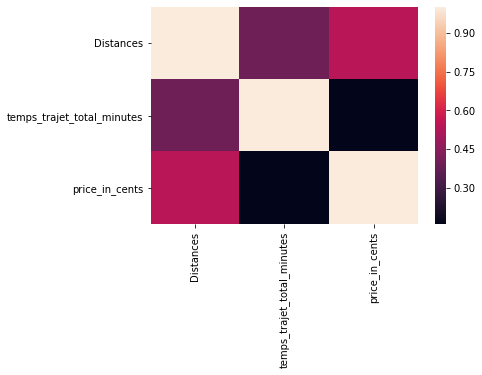

In [48]:
sns.heatmap(set_final.corr());

Etant donné la corrélation non négligeable entre la distance et le temps (ce dont on pouvait se douter), peut-être est-il préférable de ne garder que la Distance dans notre modèle prévisionnel.

In [49]:
# Set y as the target
y=set_final["price_in_cents"]

# Set X as the features
X=set_final[["Distances"]]

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
# Creation of a train set and a test set
train_X, val_X, train_y, val_y = train_test_split(X,y,test_size=0.2,random_state=1)

On peut commencer par regarder un modèle linéaire simple

In [52]:
from sklearn.linear_model import LinearRegression

/Users/arthurlemerle/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/arthurlemerle/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

In [53]:
reglin = LinearRegression().fit(train_X, train_y)

In [54]:
reglin.score(train_X,train_y)

0.2959504154450374

Le R2 étant assez faible, on constate que la relation Distance/Prix est loin d'être linéaire.

In [55]:
# Predict with all validation observations
val_predictions = reglin.predict(val_X)
print(val_predictions)

[4036.14922183 6729.94397795 6425.63123349 ... 2744.89613741 1741.67027742
 2724.29189243]


In [56]:
# print the top few validation predictions
print(val_predictions[:5])

[4036.14922183 6729.94397795 6425.63123349 2744.89613741 4672.47329   ]


In [57]:
# print the top few actual prices from validation data
print(val_y.head())

18396     2580
6420     18700
19361     3390
38559     1550
7304      3350
Name: price_in_cents, dtype: int64


Les valeurs prédites n'ont pas l'air d'être proches des valeurs réelles... Calculons l'erreur absolue moyenne :

In [58]:
from sklearn.metrics import mean_absolute_error
val_mae = mean_absolute_error(val_predictions,val_y)
print(val_mae)

2047.2338685819716


Essayons alors un modèle un peu flexible qu'une régression, comme ici une forêt d'arbres décisionnels :

In [59]:
from sklearn.ensemble import RandomForestRegressor

# We define the model
rf_model = RandomForestRegressor(100,random_state=1)

# We fit the model
rf_model.fit(train_X,train_y)

# We make predictions on validation dataset
melb_preds = rf_model.predict(val_X)

# We calculate the mean absolute error of our Random Forest model on the validation data
rf_val_mae = mean_absolute_error(val_y, melb_preds)

print("Validation MAE for Random Forest Model: {}".format(rf_val_mae))

/Users/arthurlemerle/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
/Users/arthurlemerle/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:32: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting

Validation MAE for Random Forest Model: 764.2081294619795


/Users/arthurlemerle/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


La moyenne des erreurs absolues a été grandement diminuée par rapport à une régression, de plus de 60% !
Essayons de visualiser :

/Users/arthurlemerle/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


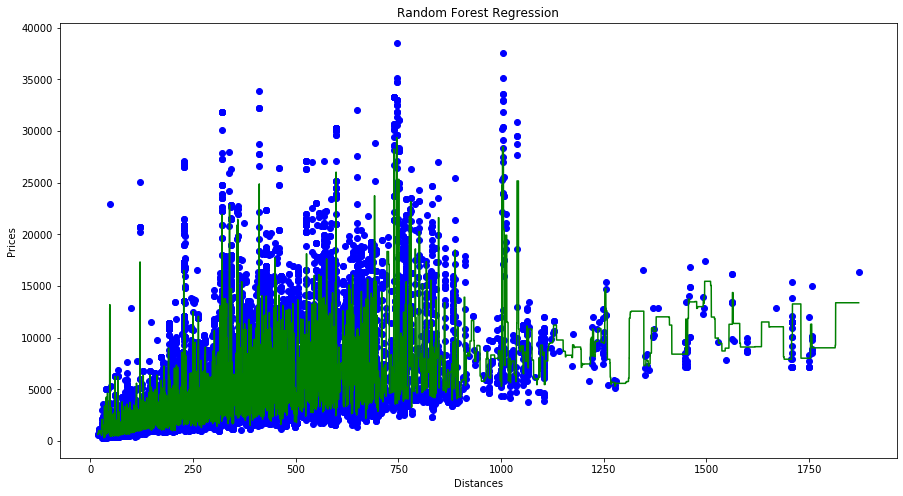

In [60]:
X_grid = np.arange(train_X.min()[0], train_X.max()[0], 0.01)
                  
X_grid = X_grid.reshape((len(X_grid), 1))
 
# Scatter plot for original data
plt.figure(1,figsize=(15,8))
plt.scatter(train_X, train_y, color = 'blue') 
 
# plot predicted data
plt.plot(X_grid, rf_model.predict(X_grid),
         color = 'green')
plt.title('Random Forest Regression')
plt.xlabel('Distances')
plt.ylabel('Prices')
plt.show()

On prend ici aussi conscience de l'énorme non-linéarité des données. Si on rajoute le temps de trajet total au modèle, voyons si on peut encore améliorer notre mean_absolute_error.

In [61]:
# We add "temps_trajet_total_minutes" to the features
X=set_final[["Distances","temps_trajet_total_minutes"]]

# We split again our data
train_X, val_X, train_y, val_y = train_test_split(X,y,test_size=0.2,random_state=1)

In [63]:
# We define the new model
rf_model2 = RandomForestRegressor(100,random_state=1)

# We fit the new model
rf_model2.fit(train_X,train_y)

# We make predictions on the validation dataset
melb_preds2 = rf_model2.predict(val_X)

# We calculate the mean absolute error of our Random Forest model on the validation data
rf_val_mae = mean_absolute_error(val_y, melb_preds2)

print("Validation MAE for Random Forest Model with 2 features: {}".format(rf_val_mae))

/Users/arthurlemerle/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Validation MAE for Random Forest Model: 564.1269934187255


On constate qu'on arrive encore un peu plus à "fitter" les données. 
Mais en voyant le graphe précédent, j'imagine tout de même qu'il y a un grand risque d'overfitting...
Essayons enfin un réseau de neurones :

In [67]:
import keras

In [68]:
resneu=keras.Sequential()

In [92]:
resneu = keras.Sequential()
resneu.add(keras.layers.Dense(units = 2, activation = 'linear', input_shape=[2]))
resneu.add(keras.layers.Dense(units = 10, activation = 'relu'))
resneu.add(keras.layers.Dense(units = 10, activation = 'relu'))
resneu.add(keras.layers.Dense(units = 10, activation = 'relu'))
resneu.add(keras.layers.Dense(units = 1, activation = 'linear'))
resneu.compile(loss='mse', optimizer="adam")
resneu.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 2)                 6         
                                                                 
 dense_25 (Dense)            (None, 10)                30        
                                                                 
 dense_26 (Dense)            (None, 10)                110       
                                                                 
 dense_27 (Dense)            (None, 10)                110       
                                                                 
 dense_28 (Dense)            (None, 1)                 11        
                                                                 
Total params: 267
Trainable params: 267
Non-trainable params: 0
_________________________________________________________________


In [93]:
train_Xresneu=train_X.to_numpy()
train_yresneu=train_y.to_numpy()

resneu.fit( train_Xresneu, train_yresneu, epochs=100, verbose=1)

Epoch 1/100
1855/1855 [==============================] - 2s 1ms/step - loss: 13570911.0000
Epoch 2/100
1855/1855 [==============================] - 2s 1ms/step - loss: 9796381.0000
Epoch 3/100
1855/1855 [==============================] - 2s 1ms/step - loss: 9618103.0000
Epoch 4/100
1855/1855 [==============================] - 2s 1ms/step - loss: 9290229.0000
Epoch 5/100
1855/1855 [==============================] - 2s 1ms/step - loss: 8892146.0000
Epoch 6/100
1855/1855 [==============================] - 2s 1ms/step - loss: 8727608.0000
Epoch 7/100
1855/1855 [==============================] - 2s 1ms/step - loss: 8573745.0000
Epoch 8/100
1855/1855 [==============================] - 2s 1ms/step - loss: 8431530.0000
Epoch 9/100
1855/1855 [==============================] - 2s 1ms/step - loss: 8382780.5000
Epoch 10/100
1855/1855 [==============================] - 2s 1ms/step - loss: 8357022.5000
Epoch 11/100
1855/1855 [==============================] - 2s 1ms/step - loss: 8339064.5000
Epoch 1

1855/1855 [==============================] - 2s 1ms/step - loss: 7729912.5000
Epoch 92/100
1855/1855 [==============================] - 3s 1ms/step - loss: 7729190.5000
Epoch 93/100
1855/1855 [==============================] - 2s 1ms/step - loss: 7729562.0000
Epoch 94/100
1855/1855 [==============================] - 2s 1ms/step - loss: 7726738.5000
Epoch 95/100
1855/1855 [==============================] - 2s 1ms/step - loss: 7726372.5000
Epoch 96/100
1855/1855 [==============================] - 2s 1ms/step - loss: 7718539.5000
Epoch 97/100
1855/1855 [==============================] - 2s 1ms/step - loss: 7719489.0000
Epoch 98/100
1855/1855 [==============================] - 2s 1ms/step - loss: 7715727.5000
Epoch 99/100
1855/1855 [==============================] - 2s 1ms/step - loss: 7710203.0000
Epoch 100/100
1855/1855 [==============================] - 2s 1ms/step - loss: 7712726.5000


In [94]:
val_Xresneu=val_X.to_numpy()
val_yresneu=val_y.to_numpy()

In [95]:
y_predictions=resneu.predict(val_Xresneu)

In [96]:
mae_resneu=mean_absolute_error(val_yresneu,y_predictions)
print(mae_resneu)

1529.4910241309983


On constate que notre réseau de neurones -construit totalement au hasard- a de moins bonnes performances que notre forêt d'arbres décisionnels. Sans doute lui faudrait-il plus d'entrainement et une "meilleure" architecture pour gagner en performance.

Il y a évidemment énormément de choses qu'on aurait pu faire différemment sur les prédictions ci-dessus : travailler par type de moyen de transport (d'ailleurs sans doute plus judicieux je pense), ou inclure directement le moyen de transport comme prédicteur. 